# Example and features

We will consider a bridge grillage model created using the `ospgrillage` module
as our running example to demonstrate the features of `calabru`.

In [1]:
import calabru as clb # calabru package
import numpy as np # for numerical arrays
import matplotlib.pyplot as plt # for plotting
from IPython import display # For images in notebook
import pycba as cba # for creating beam model
import ospgrillage as og
%matplotlib inline 


## Exploring parameter options

### Inputs

`calabru` takes multiple inputs for the updating parameters as a list.

In [2]:
start = [
         0.2, 
         0.4,
         0.6,
        ]

We can introduce bounds which the parameters will not exceed during the calibration process as follows:

In [3]:
bounds = [
          [0.1,0.5], # lower and upper bounds for first param 
          [0.7], # upper bound of second param, lower default to zero 
          [], # no bounds for third param
         ]

where the `bounds` list must be the same size as the `start` list.
Each element should be a  list of a lower and upper bound (second entry).

### Targets

Each target responses can be a list/array.

For example, we have can have the deflected shape list and the force magnitude of Element 5 as the first and second element the list of `target` respectively.

In [4]:
target = [
    5948.52,  # element forces
    [
        0.0,
        5.244e-05,
        9.984e-05,
        0.000136,
        0.0001558,
        0.0001558,
        0.000136,
        9.984e-05,
        5.243e-05,
        0.0,
    ], # node displacements
    
] 

## Example 1 - Grillage model problem in ospgrillage

We have a full-fledged single-span bridge model made using `ospgrillage` module that we'd like to use to determine the bridge load effects due to an imposed load.


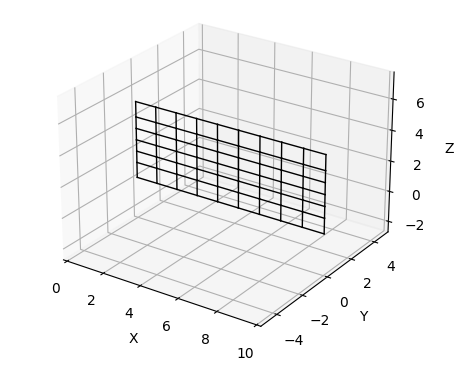

In [11]:
display.Image("../images/osp_example.png",width=800)

We want to update the moment of inertia of the longitudinal girders (`I`) of the bridge model. In addition, we are uncertain of the moment of inertia of the two edge members as well. Therefore, we introduce two updating paramters to the model as:

In [6]:
start = [0.2, # longitudinal girders, I
           0.1, # edge member, I
          ]

We update the model using some "known" measurements of the bridge deflections. For this,the measurements is taken as the
responses which corresponds to a parameter list = [0.5,0.1]


In [7]:
target = [[1047.057906932444,
  [0.0,
   3.847756717425916e-05,
   7.335795722107879e-05,
   0.0001001430188545662,
   0.00011472208165921942,
   0.00011472208165922035,
   0.00010014301885456844,
   7.335795722108123e-05,
   3.847756717426085e-05,
   0.0]]
]

Lets create the function handler (denote as `main()`) that creates and analyse the model with the following properties that is compatible with`calabru` to allow for updating procedures:

1. `main()` takes in `I_start` as an argument.
2. `main()` returns a list of the corresponding measurables of `target_deflections` from the model.

In [8]:
def main(p_matrix: list):
    # sort parameter variable

    P = 1000
    Iz1 = p_matrix[0]
    Iz2 = p_matrix[1]

    # Adopted units: N and m
    kilo = 1e3
    milli = 1e-3
    N = 1
    m = 1
    mm = milli * m
    m2 = m ** 2
    m3 = m ** 3
    m4 = m ** 4
    kN = kilo * N
    MPa = N / ((mm) ** 2)
    GPa = kilo * MPa

    # parameters of bridge grillage
    L = 10 * m  # span
    w = 5 * m  # width
    n_l = 7  # number of longitudinal members
    n_t = 10  # number of transverse members
    edge_dist = 1 * m  # distance between edge beam and first exterior beam
    ext_to_int_dist = (
        2.2775 * m
    )  # distance between first exterior beam and first interior beam
    angle = 0  # skew angle
    mesh_type = "Oblique"

    # define material
    concrete = og.create_material(
        material="concrete", code="AS5100-2017", grade="65MPa"
    )

    # define sections (parameters from LUSAS model)
    edge_longitudinal_section = og.create_section(
        A=0.934 * m2,
        J=0.1857 * m3,
        Iz=Iz2 * m4,
        Iy=0.213602 * m4,
        Az=0.444795 * m2,
        Ay=0.258704 * m2,
    )

    longitudinal_section = og.create_section(
        A=1.025 * m2,
        J=0.1878 * m3,
        Iz=Iz1 * m4,
        Iy=0.113887e-3 * m4,
        Az=0.0371929 * m2,
        Ay=0.0371902 * m2,
    )

    transverse_section = og.create_section(
        A=0.504 * m2,
        J=5.22303e-3 * m3,
        Iy=0.32928 * m4,
        Iz=1.3608e-3 * m4,
        Ay=0.42 * m2,
        Az=0.42 * m2,
    )

    end_transverse_section = og.create_section(
        A=0.504 / 2 * m2,
        J=2.5012e-3 * m3,
        Iy=0.04116 * m4,
        Iz=0.6804e-3 * m4,
        Ay=0.21 * m2,
        Az=0.21 * m2,
    )

    # define grillage members
    longitudinal_beam = og.create_member(
        section=longitudinal_section, material=concrete
    )
    edge_longitudinal_beam = og.create_member(
        section=edge_longitudinal_section, material=concrete
    )
    transverse_slab = og.create_member(section=transverse_section, material=concrete)
    end_transverse_slab = og.create_member(
        section=end_transverse_section, material=concrete
    )

    # create grillage
    simple_bridge = og.create_grillage(
        bridge_name="simple_bridge",
        long_dim=L,
        width=w,
        skew=angle,
        num_long_grid=n_l,
        num_trans_grid=n_t,
        edge_beam_dist=edge_dist,
        mesh_type=mesh_type,
    )

    simple_bridge.set_member(longitudinal_beam, member="interior_main_beam")
    simple_bridge.set_member(longitudinal_beam, member="exterior_main_beam_1")
    simple_bridge.set_member(longitudinal_beam, member="exterior_main_beam_2")
    simple_bridge.set_member(edge_longitudinal_beam, member="edge_beam")
    simple_bridge.set_member(transverse_slab, member="transverse_slab")
    simple_bridge.set_member(end_transverse_slab, member="start_edge")
    simple_bridge.set_member(end_transverse_slab, member="end_edge")
    simple_bridge.create_osp_model(pyfile=False)

    # add load case
    # Patch load over entire bridge deck (P is kN/m2)
    P = P * kN / m2  # magnitude of patch vertex
    patch_point_1 = og.create_load_vertex(x=0, z=0, p=P)
    patch_point_2 = og.create_load_vertex(x=L, z=0, p=P)
    patch_point_3 = og.create_load_vertex(x=L, z=w, p=P)
    patch_point_4 = og.create_load_vertex(x=0, z=w, p=P)
    test_patch_load = og.create_load(
        loadtype="patch",
        name="Test Load",
        point1=patch_point_1,
        point2=patch_point_2,
        point3=patch_point_3,
        point4=patch_point_4,
    )

    test_point_load = og.create_load(
        loadtype="point",
        name="Test Load",
        point1=og.create_load_vertex(x=L / 2, z=w / 2, p=P),
    )

    # Create load case, add loads, and assign
    patch_case = og.create_load_case(name="test patch load case")
    patch_case.add_load(test_patch_load)
    point_case = og.create_load_case(name="test point load case")
    point_case.add_load(test_point_load)
    # sn8474.add_load_case(patch_case)
    simple_bridge.add_load_case(point_case)

    simple_bridge.analyze()
    results = simple_bridge.get_results()

    # arbitrary force components
    r_mat = [[og.ops.eleForce(25)[1],[og.ops.nodeDisp(n)[1] for n in [2,9,16,23,30,37,44,51,58,65]]]]

    return r_mat

In [9]:
simple_beam_updating = clb.ModelUpdating(
    function_handle=main,
    param_list=start,
    target_list=target,
    max_error=0.1,
    write_output_txt=False
)


In [10]:
simple_beam_updating.update_model()
print(simple_beam_updating.param_update_history)

[[0.2, 0.1], [0.3365125562453617, 0.10119151305405859], [0.45716219684186105, 0.1008159604001884], [0.5002470885555945, 0.10009323201609568]]


As can be seen the values converged to [0.5,0.1] 